<a href="https://colab.research.google.com/github/HirokJB/Uber-Fare-Prediction-Regression/blob/main/Uber_Fares_Prediction_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset Details

Description:
The project is about on world's largest taxi company Uber inc. In this project, we're looking to predict the fare for their future transactional cases. Uber delivers service to lakhs of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

The dataset contains the following fields:
key - a unique identifier for each trip

fare_amount - the cost of each trip in usd

pickup_datetime - date and time when the meter was engaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

**Acknowledgement**:

The dataset is referred from Kaggle.

**Objective**:

Understand the Dataset & cleanup (if required).

Build Regression models to predict the fare price of uber ride.

Also evaluate the models & compare thier respective scores like R2, RMSE, etc.

In [148]:
import pandas as pd
import numpy as np
import seaborn as snas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [150]:
path='/content/drive/MyDrive/uber.csv'
df=pd.read_csv(path)

In [151]:
df.shape

(200000, 9)

In [152]:
df.sample(5)

Unnamed: 0                            key  fare_amount  \
162068    14383914   2014-03-11 18:44:00.00000018          6.5   
147616    47060494    2011-06-04 16:57:16.0000002          4.1   
88265     22459268   2011-04-07 05:38:00.00000020          7.7   
66921     15223694    2013-04-11 01:08:56.0000001         14.0   
31185      6948153  2012-11-25 21:13:00.000000163         17.5   

                pickup_datetime  pickup_longitude  pickup_latitude  \
162068  2014-03-11 18:44:00 UTC        -73.994418        40.726355   
147616  2011-06-04 16:57:16 UTC        -73.999709        40.741080   
88265   2011-04-07 05:38:00 UTC          0.000000         0.000000   
66921   2013-04-11 01:08:56 UTC        -73.988983        40.722892   
31185   2012-11-25 21:13:00 UTC        -73.997065        40.722215   

        dropoff_longitude  dropoff_latitude  passenger_count  
162068         -73.988602         40.739287                2  
147616         -73.994823         40.750318                1  
88265            0.000000          0.000000                1  
66921          -73.950406         40.684326                1  
31185          -73.948495         40.778127                1

## Data cleaning and pre-processing

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [154]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [155]:
df.dropna(inplace=True)

In [156]:
df.shape

(199999, 9)

### No missing values left

In [157]:
df.duplicated().sum()

0

### No duplicate values left

In [158]:
## Dropping the unnamed column.
df.drop('Unnamed: 0',axis=1,inplace=True)

In [159]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [160]:
df['pickup_datetime'].dtypes

datetime64[ns, UTC]

### Feature Extraction

In [161]:
df['Year'] = df['pickup_datetime'].apply(lambda time: time.year)
df['Date'] = df['pickup_datetime'].apply(lambda time: time.day)
df['Hour'] = df['pickup_datetime'].apply(lambda time: time.hour)
df['Month'] = df['pickup_datetime'].dt.month_name()
df['Day of Week'] = df['pickup_datetime'].dt.day_name()

In [162]:
df

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199997   2009-06-29 00:42:00.00000078         30.9 2009-06-29 00:42:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199997        -73.986017        40.756487         -73.858957   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199997         40.692588                2  2009    29     0     June   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  
0         Thursday  
1           Friday  
2           Monday  
3           Friday  
4         Thursday  
...            ...  
199995      Sunday  
199996      Friday  
199997      Monday  
199998   Wednesday  
199999    Saturday  

[199999 rows x 13 columns]

### percentage of data which has no information about pick_up latitude and longitude , the drop_off lattitude and longitude

In [163]:
round(df[(df['pickup_latitude'] == 0) & (df['pickup_longitude'] == 0)&(df['dropoff_latitude'] == 0)&(df['dropoff_longitude'] == 0)].shape[0]/len(df)*100,2)


1.79

In [164]:
df = df[~((df['pickup_latitude'] == 0) & (df['pickup_longitude'] == 0) & (df['dropoff_latitude'] == 0) & (df['dropoff_longitude'] == 0))]

In [165]:
df.shape ## Shape of new dataframe.

(196412, 13)

#### Checking zero values in pickup longitude

In [166]:
df=df[~(df['pickup_longitude']==0)]

In [167]:
df.shape # Dataframe after dropping pickup longitude zero values.

(196213, 13)

#### Checking zero values in pickup lattitude

In [168]:
df=df[~(df['pickup_latitude']==0)]

In [169]:
df.shape ## Dataframe after dropping pickup latitude zero values.

(196210, 13)

#### Checking zero values in dropoff lattitude and longitude

In [170]:
df=df[~(df['dropoff_longitude']==0)]

In [171]:
df1=df[~(df['dropoff_latitude']==0)]

#### Dataframe after dropping zero values from latitudes and longitudes

In [172]:
df1.shape ## Final dataframe after dropping zero values from latitudes and longitudes

(196031, 13)

#### Checking Fare_Amount target Column

In [173]:
df2=df1[~(df1['fare_amount']<=0)] ## Removing negative and zero fare amount rows from dataframe

In [174]:
df2.shape

(196012, 13)

#### Checking passenger_count variable

In [175]:
df2['passenger_count'].value_counts()

1      135633
2       28863
5       13739
3        8705
6        4202
4        4183
0         686
208         1
Name: passenger_count, dtype: int64

In [176]:
df3 = df2[~((df2['passenger_count'] == 0) | (df2['passenger_count'] > 6))]

In [177]:
df3.shape

(195325, 13)

### Checking for validity of longitudes and latitudes
#### Typically, latitudes range from -90 to 90, and longitude range from 180 and -180.

In [178]:
df4=df3[~((df3['pickup_longitude']>180) | (df3['pickup_longitude']<-180))]

In [179]:
df4=df4[~((df4['dropoff_longitude']>180) | (df4['dropoff_longitude']<-180))]

In [180]:
df4=df4[~((df4['pickup_latitude']>90) | (df4['pickup_latitude']<-90))]

In [181]:
df4=df4[~((df4['dropoff_latitude']>90) | (df4['dropoff_latitude']<-90))]

In [182]:
df5=df4
df5

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199997   2009-06-29 00:42:00.00000078         30.9 2009-06-29 00:42:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199997        -73.986017        40.756487         -73.858957   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199997         40.692588                2  2009    29     0     June   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  
0         Thursday  
1           Friday  
2           Monday  
3           Friday  
4         Thursday  
...            ...  
199995      Sunday  
199996      Friday  
199997      Monday  
199998   Wednesday  
199999    Saturday  

[195313 rows x 13 columns]

### Feature Construction

In [183]:
## Manhattan Distance.
df5['manhattan_distance'] = abs(df5['pickup_longitude'] - df5['dropoff_longitude']) + abs(df5['pickup_latitude'] - df5['dropoff_latitude'])

In [184]:
df5

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199997   2009-06-29 00:42:00.00000078         30.9 2009-06-29 00:42:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199997        -73.986017        40.756487         -73.858957   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199997         40.692588                2  2009    29     0     June   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  manhattan_distance  
0         Thursday            0.015442  
1           Friday            0.022455  
2           Monday            0.074355  
3           Friday            0.023313  
4         Thursday            0.065221  
...            ...                 ...  
199995      Sunday            0.001447  
199996      Friday            0.024733  
199997      Monday            0.190959  
199998   Wednesday            0.043945  
199999    Saturday            0.049829  

[195313 rows x 14 columns]

## Analysing the variables

### Manhattan distance

In [185]:
df5['manhattan_distance'].describe()

count    195313.000000
mean          0.057527
std           0.945635
min           0.000000
25%           0.016407
50%           0.028161
75%           0.050839
max         114.768053
Name: manhattan_distance, dtype: float64

### Removing the probable outliers > (Q3+3*IQR), as per Tukey's.

In [186]:
df6=df5[~(df5['manhattan_distance'] > (df5['manhattan_distance'].quantile(0.75) + 3 * (df5['manhattan_distance'].quantile(0.75) - df5['manhattan_distance'].quantile(0.25))))]

In [187]:
df6

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199994  2014-01-31 14:42:00.000000181         12.0 2014-01-31 14:42:00+00:00   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199994        -73.983070        40.760770         -73.972972   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199994         40.754177                1  2014    31    14  January   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  manhattan_distance  
0         Thursday            0.015442  
1           Friday            0.022455  
2           Monday            0.074355  
3           Friday            0.023313  
4         Thursday            0.065221  
...            ...                 ...  
199994      Friday            0.016691  
199995      Sunday            0.001447  
199996      Friday            0.024733  
199998   Wednesday            0.043945  
199999    Saturday            0.049829  

[188055 rows x 14 columns]

### Also Manhattan distance cannot be equal to zero.

In [188]:
df7=df6[~(df6['manhattan_distance']==0)]

In [189]:
df7

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199994  2014-01-31 14:42:00.000000181         12.0 2014-01-31 14:42:00+00:00   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199994        -73.983070        40.760770         -73.972972   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199994         40.754177                1  2014    31    14  January   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  manhattan_distance  
0         Thursday            0.015442  
1           Friday            0.022455  
2           Monday            0.074355  
3           Friday            0.023313  
4         Thursday            0.065221  
...            ...                 ...  
199994      Friday            0.016691  
199995      Sunday            0.001447  
199996      Friday            0.024733  
199998   Wednesday            0.043945  
199999    Saturday            0.049829  

[186012 rows x 14 columns]

In [190]:
df7['manhattan_distance'].describe()

count    1.860120e+05
mean     3.664911e-02
std      2.910558e-02
min      1.000000e-06
25%      1.634573e-02
50%      2.741650e-02
75%      4.712700e-02
max      1.541250e-01
Name: manhattan_distance, dtype: float64

In [191]:
# Calculate the quartile values
q1 = df7['manhattan_distance'].quantile(0.25)
q2 = df7['manhattan_distance'].quantile(0.5)
q3 = df7['manhattan_distance'].quantile(0.75)

# Calculate the whisker values
iqr = q3 - q1
lower = q1 - 3 * iqr
upper = q3 + 3 * iqr
print("Probable outlier's would be any value below ",lower,'or any value above',upper)

Probable outlier's would be any value below  -0.07599806665037079 or any value above 0.13947079998777134


### Removing any value beyond this range , treating the probable outliers

In [192]:
df8=df7[(df7['manhattan_distance']>-0.07599806665037079)|(df7['manhattan_distance']<0.13947079998777134)]

In [193]:
df8.shape

(186012, 14)

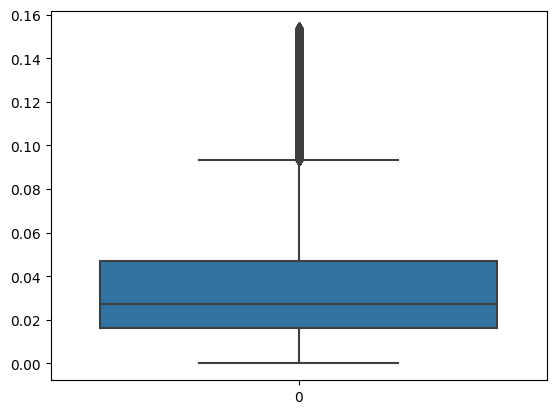

In [194]:
sns.boxplot(df8['manhattan_distance'])
plt.show() ## Whiskers here are at 1.5IQR but we have removed only values which are beyond 3*IQR.

In [195]:
df8['manhattan_distance'].sort_values(ascending=True).head(15)

14116     1.000000e-06
119189    1.000000e-06
176333    1.000000e-06
32378     1.000000e-06
198655    1.000000e-06
1531      1.000000e-06
198842    1.000000e-06
76904     1.000000e-06
42732     1.000000e-06
163148    1.000000e-06
113686    1.000000e-06
70529     2.000000e-06
185415    2.000000e-06
125257    2.000000e-06
127197    2.000000e-06
Name: manhattan_distance, dtype: float64

### We see there are manhattan distance values which are very small, this is anomalous.  We need to treat them as well. But we will check it later.



## Fare_Amount

In [196]:
df8['fare_amount'].describe()

count    186012.000000
mean         10.087343
std           6.787497
min           0.010000
25%           6.000000
50%           8.100000
75%          12.000000
max         499.000000
Name: fare_amount, dtype: float64

In [197]:
df8['fare_amount'].value_counts().sort_index()

0.01        2
0.11        1
2.50      577
2.90      439
3.00      328
         ... 
180.00      1
183.00      1
196.00      1
220.00      1
499.00      1
Name: fare_amount, Length: 807, dtype: int64

### For any car ride service there is a base fare, here, from the data points , we are assuming this base fare is 2.5. hence we are removing all the rows with fare less than and equal to 2.5

In [198]:
df9=df8[df8['fare_amount']>2.5]

In [199]:
df9

key  fare_amount           pickup_datetime  \
0         2015-05-07 19:52:06.0000003          7.5 2015-05-07 19:52:06+00:00   
1         2009-07-17 20:04:56.0000002          7.7 2009-07-17 20:04:56+00:00   
2        2009-08-24 21:45:00.00000061         12.9 2009-08-24 21:45:00+00:00   
3         2009-06-26 08:22:21.0000001          5.3 2009-06-26 08:22:21+00:00   
4       2014-08-28 17:47:00.000000188         16.0 2014-08-28 17:47:00+00:00   
...                               ...          ...                       ...   
199994  2014-01-31 14:42:00.000000181         12.0 2014-01-31 14:42:00+00:00   
199995   2012-10-28 10:49:00.00000053          3.0 2012-10-28 10:49:00+00:00   
199996    2014-03-14 01:09:00.0000008          7.5 2014-03-14 01:09:00+00:00   
199998    2015-05-20 14:56:25.0000004         14.5 2015-05-20 14:56:25+00:00   
199999   2010-05-15 04:08:00.00000076         14.1 2010-05-15 04:08:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355        40.728225         -73.994710   
2             -74.005043        40.740770         -73.962565   
3             -73.976124        40.790844         -73.965316   
4             -73.925023        40.744085         -73.973082   
...                  ...              ...                ...   
199994        -73.983070        40.760770         -73.972972   
199995        -73.987042        40.739367         -73.986525   
199996        -73.984722        40.736837         -74.006672   
199998        -73.997124        40.725452         -73.983215   
199999        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  Year  Date  Hour    Month  \
0              40.723217                1  2015     7    19      May   
1              40.750325                1  2009    17    20     July   
2              40.772647                1  2009    24    21   August   
3              40.803349                3  2009    26     8     June   
4              40.761247                5  2014    28    17   August   
...                  ...              ...   ...   ...   ...      ...   
199994         40.754177                1  2014    31    14  January   
199995         40.740297                1  2012    28    10  October   
199996         40.739620                1  2014    14     1    March   
199998         40.695415                1  2015    20    14      May   
199999         40.768793                1  2010    15     4      May   

       Day of Week  manhattan_distance  
0         Thursday            0.015442  
1           Friday            0.022455  
2           Monday            0.074355  
3           Friday            0.023313  
4         Thursday            0.065221  
...            ...                 ...  
199994      Friday            0.016691  
199995      Sunday            0.001447  
199996      Friday            0.024733  
199998   Wednesday            0.043945  
199999    Saturday            0.049829  

[185432 rows x 14 columns]

In [200]:
# Calculate the quartile values
q1 = df9['fare_amount'].quantile(0.25)
q2 = df9['fare_amount'].quantile(0.5)
q3 = df9['fare_amount'].quantile(0.75)

# Calculate the fences values
iqr = q3 - q1
lower = q1 - 3 * iqr
upper = q3 + 3 * iqr
print("Probable outlier's would be any value below ",lower,'or any value above',upper)

Probable outlier's would be any value below  -12.0 or any value above 30.0


### Removing probable outlier's here, because the purpose is prediction of Uber Fares rather than only analysis of variables.

In [201]:
df10=df9[df9['fare_amount']<30]

In [202]:
df10['manhattan_distance'].sort_values(ascending=True)

76904     0.000001
125257    0.000002
8243      0.000002
141159    0.000002
48771     0.000002
            ...   
39004     0.153972
113853    0.154060
141127    0.154073
146165    0.154112
72986     0.154123
Name: manhattan_distance, Length: 181462, dtype: float64

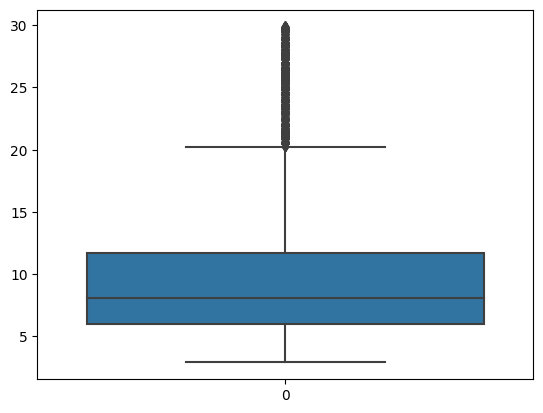

In [203]:
sns.boxplot(df10['fare_amount'])
plt.show() ## whisker's are 1.5 IQR but we have removed only values which are above 3*IQR.

In [204]:
final_df=df10
print('% of rows dropped in the final dataframe is',round((200000-len(final_df))/200000*100,2))

% of rows dropped in the final dataframe is 9.27


## Exploratory Data Analysis

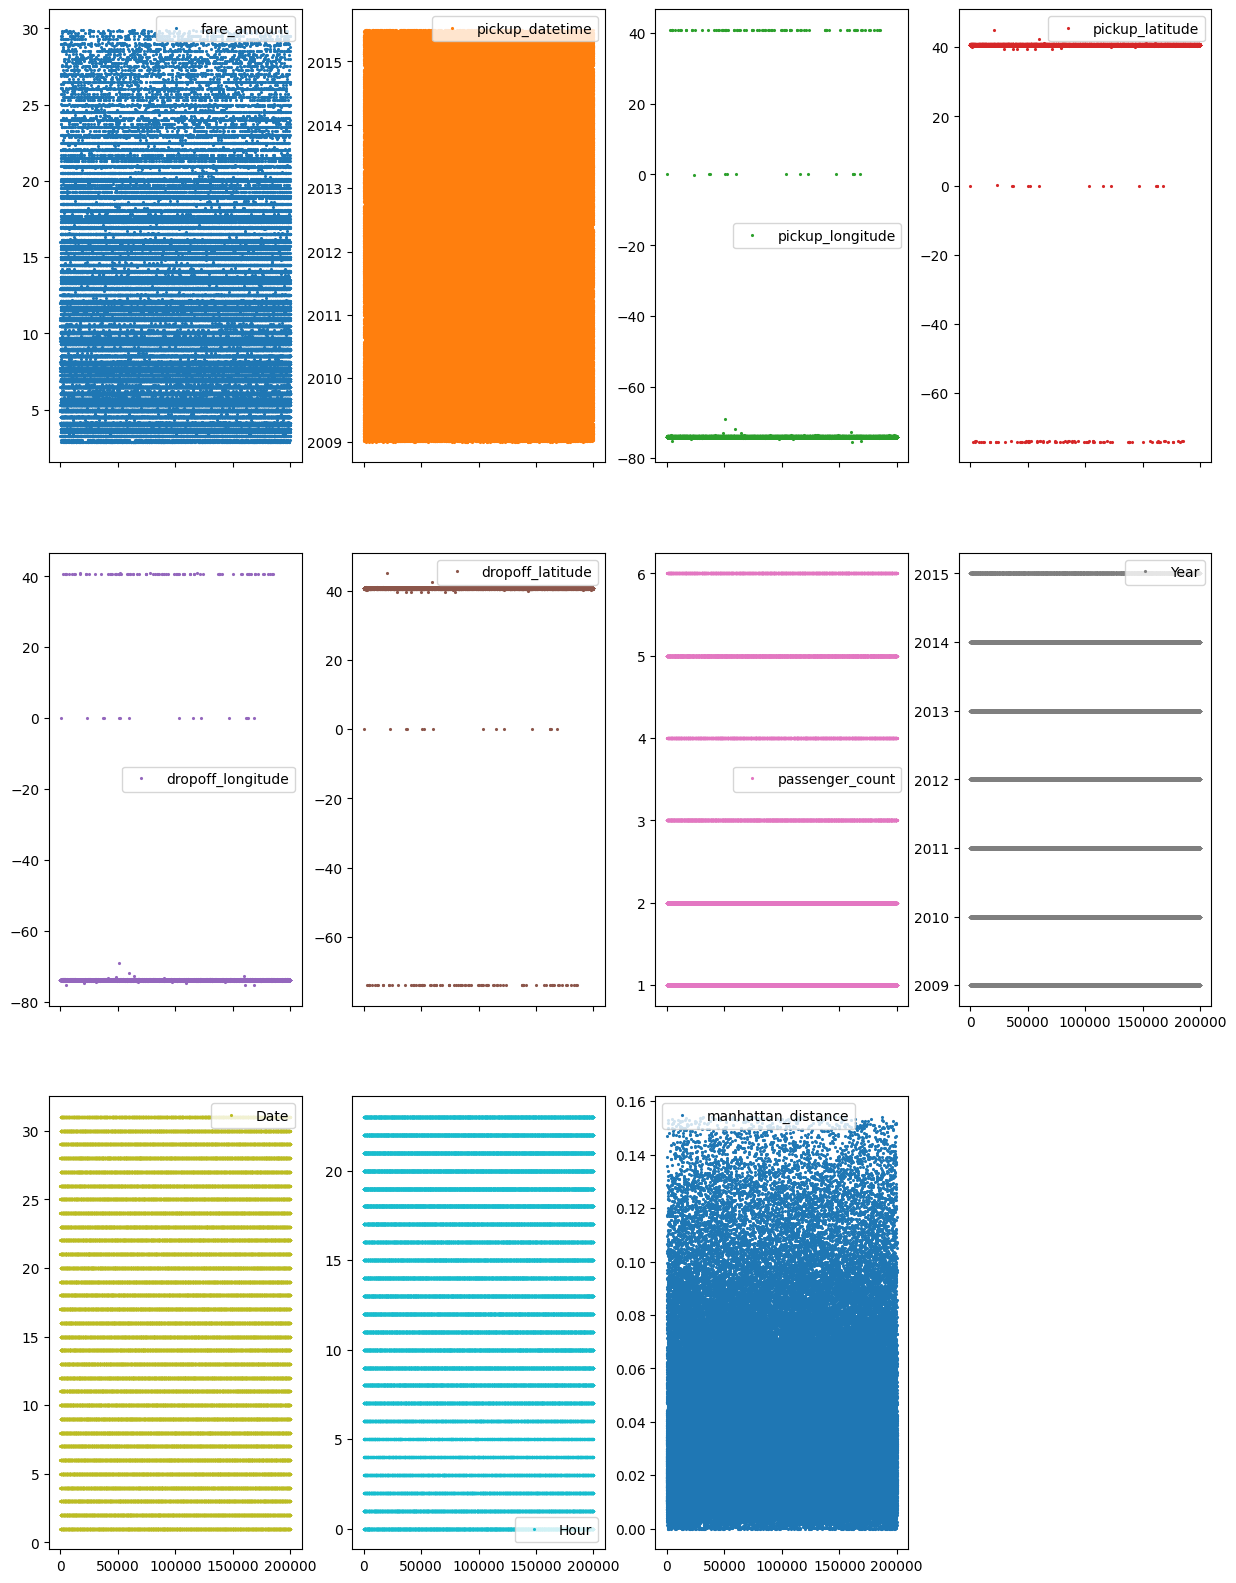

In [205]:
##Basic understanding of numerical data

final_df.plot(lw=0,marker='.',subplots=True,layout=(-1,4),figsize=(15,20),markersize=2.5)
plt.show()

In [206]:
final_df.corr()

fare_amount  pickup_longitude  pickup_latitude  \
fare_amount            1.000000          0.006319        -0.005689   
pickup_longitude       0.006319          1.000000        -0.993291   
pickup_latitude       -0.005689         -0.993291         1.000000   
dropoff_longitude      0.007281          0.999961        -0.993305   
dropoff_latitude      -0.006122         -0.993293         0.999953   
passenger_count        0.009876          0.009132        -0.009349   
Year                   0.132726          0.012723        -0.014050   
Date                   0.004724          0.018803        -0.019386   
Hour                  -0.017136          0.002788        -0.002119   
manhattan_distance     0.833600          0.002113        -0.002662   

                    dropoff_longitude  dropoff_latitude  passenger_count  \
fare_amount                  0.007281         -0.006122         0.009876   
pickup_longitude             0.999961         -0.993293         0.009132   
pickup_latitude             -0.993305          0.999953        -0.009349   
dropoff_longitude            1.000000         -0.993269         0.009154   
dropoff_latitude            -0.993269          1.000000        -0.009313   
passenger_count              0.009154         -0.009313         1.000000   
Year                         0.012775         -0.014009         0.003168   
Date                         0.018781         -0.019387         0.002960   
Hour                         0.002341         -0.002202         0.015662   
manhattan_distance           0.003486         -0.002556        -0.000160   

                        Year      Date      Hour  manhattan_distance  
fare_amount         0.132726  0.004724 -0.017136            0.833600  
pickup_longitude    0.012723  0.018803  0.002788            0.002113  
pickup_latitude    -0.014050 -0.019386 -0.002119           -0.002662  
dropoff_longitude   0.012775  0.018781  0.002341            0.003486  
dropoff_latitude   -0.014009 -0.019387 -0.002202           -0.002556  
passenger_count     0.003168  0.002960  0.015662           -0.000160  
Year                1.000000 -0.010875  0.002204           -0.015843  
Date               -0.010875  1.000000  0.005790            0.006674  
Hour                0.002204  0.005790  1.000000           -0.043819  
manhattan_distance -0.015843  0.006674 -0.043819            1.000000

## Target Variable=Fare_Amount

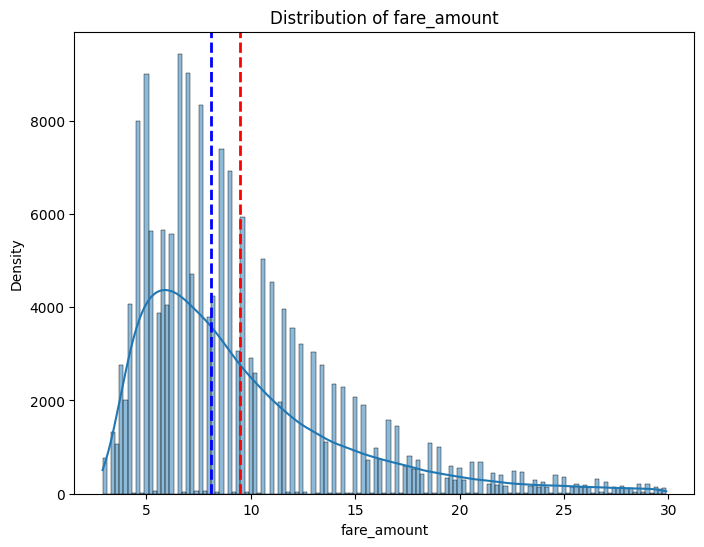

In [207]:
# Histogram of 'fare_amount'
plt.figure(figsize=(8, 6))
sns.histplot(final_df['fare_amount'], kde=True)
plt.xlabel('fare_amount')
plt.ylabel('Density')
plt.title('Distribution of fare_amount')


# Add vertical lines for mean and median
plt.axvline(final_df['fare_amount'].mean(), color='red', linestyle='dashed', linewidth=2) ## Red line is Mean.
plt.axvline(final_df['fare_amount'].median(), color='blue', linestyle='dashed', linewidth=2)

plt.show()

#### This shows a right skewed distribution.

In [208]:
## Using Shapiro-Wilk's test.
from scipy.stats import shapiro

# Checking if target variable is normal or not.
stat, p_value = shapiro(final_df['fare_amount'])

alpha = 0.05  # Set significance level
if p_value > alpha:
    print("Data follows a normal distribution.")
else:
    print("Data does not follow a normal distribution.")

Data does not follow a normal distribution.


#### It's an important finding, because we will be using linear regression which assumes normality of data.

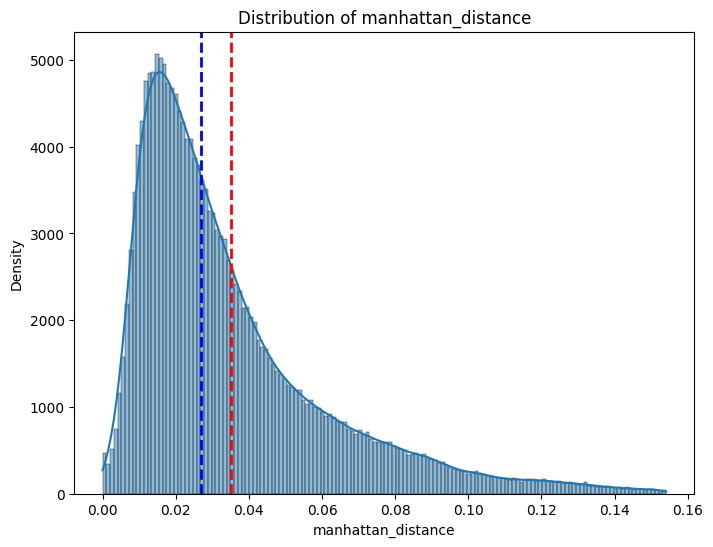

In [209]:
# Histogram of 'manhattan_distance'
plt.figure(figsize=(8, 6))
sns.histplot(final_df['manhattan_distance'], kde=True)
plt.xlabel('manhattan_distance')
plt.ylabel('Density')
plt.title('Distribution of manhattan_distance')


# Add vertical lines for mean and median
plt.axvline(final_df['manhattan_distance'].mean(), color='red', linestyle='dashed', linewidth=2) ## Red line is Mean.
plt.axvline(final_df['manhattan_distance'].median(), color='blue', linestyle='dashed', linewidth=2)
plt.show()


#### Thus, data is right skewed.

In [210]:
## Using Shapiro-Wilk's test.
from scipy.stats import shapiro

# Checking if target variable is normal or not.
stat, p_value = shapiro(final_df['manhattan_distance'])

alpha = 0.05  # Set significance level
if p_value > alpha:
    print("Data follows a normal distribution.")
else:
    print("Data does not follow a normal distribution.")

Data does not follow a normal distribution.


In [211]:
import plotly.express as px

# Create a scatter map plot using Plotly
fig = px.scatter_mapbox(final_df,
                        lat="pickup_latitude",
                        lon="pickup_longitude",
                        color="fare_amount",
                        zoom=10,
                        mapbox_style="carto-positron")

# Display the map plot
fig.show()

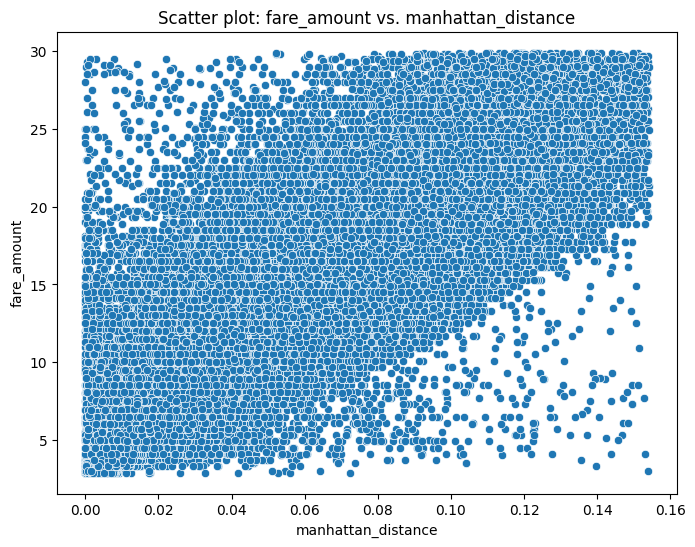

In [212]:
# Scatter plot of 'fare_amount' vs. 'manhattan_distance'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=final_df['manhattan_distance'], y=final_df['fare_amount'])
plt.xlabel('manhattan_distance')
plt.ylabel('fare_amount')
plt.title('Scatter plot: fare_amount vs. manhattan_distance')
plt.show()

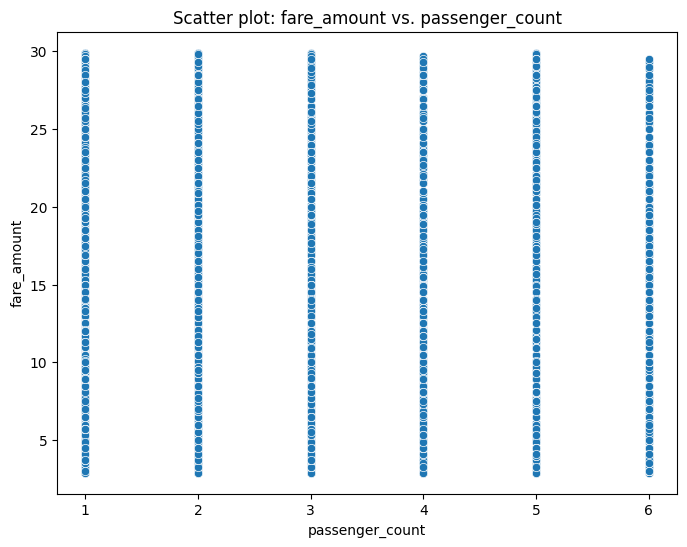

In [213]:
# Scatter plot of 'fare_amount' vs. 'passenger_count'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=final_df['passenger_count'], y=final_df['fare_amount'])
plt.xlabel('passenger_count')
plt.ylabel('fare_amount')
plt.title('Scatter plot: fare_amount vs. passenger_count')
plt.show()

### We could clearly see, the passenger count takes discrete values . Henceforth, we will treat it as categorical variable.

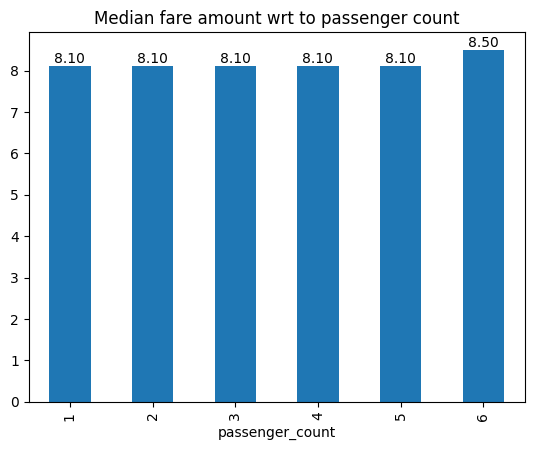

In [214]:
ax=final_df.groupby('passenger_count')['fare_amount'].median().sort_values().plot(kind='bar')
plt.bar_label(ax.containers[0],fmt='%.2f')
plt.title('Median fare amount wrt to passenger count')
plt.show()

### there seems to be no relationship between passenger count and fare amount.

In [215]:
final_df.groupby('Year')['fare_amount'].mean()

Year
2009     8.753388
2010     8.803071
2011     8.912502
2012     9.437389
2013    10.249436
2014    10.445234
2015    10.383465
Name: fare_amount, dtype: float64

In [216]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
final_df.groupby(['Year','Month'])['fare_amount'].mean().unstack().reindex(columns=month_order)


Month   January   February      March      April        May       June  \
Year                                                                     
2009   8.674194   8.659118   8.772762   8.830176   8.690407   8.844534   
2010   8.425803   8.557091   8.558181   8.772692   8.785008   8.953150   
2011   8.592111   8.703872   8.830802   8.903512   8.783584   9.014633   
2012   8.541255   8.883662   8.837125   9.061542   9.376159   9.070161   
2013   9.700501   9.982801   9.901134  10.255209  10.425819  10.314834   
2014   9.875907  10.129167  10.141387  10.575144  10.642502  10.672351   
2015   9.925878  10.236506  10.303975  10.420014  10.695234  10.710918   

Month       July     August  September    October   November   December  
Year                                                                     
2009    8.825251   8.659017   8.721758   8.827924   8.914099   8.616747  
2010    8.876850   8.845946   8.960259   9.166472   8.682251   9.008510  
2011    8.956764   8.960764   9.077351   9.004663   9.113311   8.988387  
2012    9.068267   9.011005  10.381669  10.594396  10.290245  10.219633  
2013   10.453554  10.166652  10.489266  10.497713  10.394166  10.423455  
2014   10.509230  10.405903  10.584808  10.616587  10.541404  10.676379  
2015         NaN        NaN        NaN        NaN        NaN        NaN

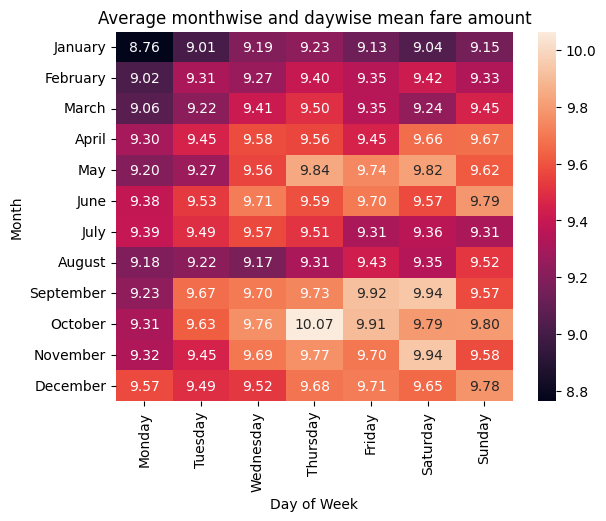

In [217]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
data1=final_df.groupby(['Month','Day of Week'])['fare_amount'].mean().unstack().reindex(index=month_order, columns=day_order)
sns.heatmap(data1,annot=True,fmt='.2f')
plt.title('Average monthwise and daywise mean fare amount')
plt.show()

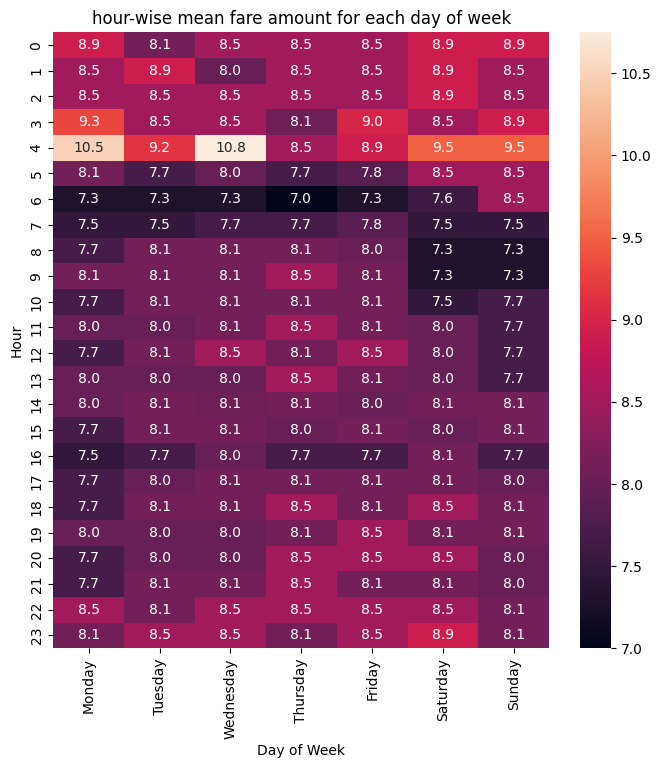

In [218]:
data_1=final_df.groupby(['Day of Week','Hour'])['fare_amount'].median().unstack().T.reindex(columns=day_order)
plt.figure(figsize=(8,8))
sns.heatmap(data_1,annot=True,fmt='.1f')
plt.title('hour-wise mean fare amount for each day of week')


plt.show()

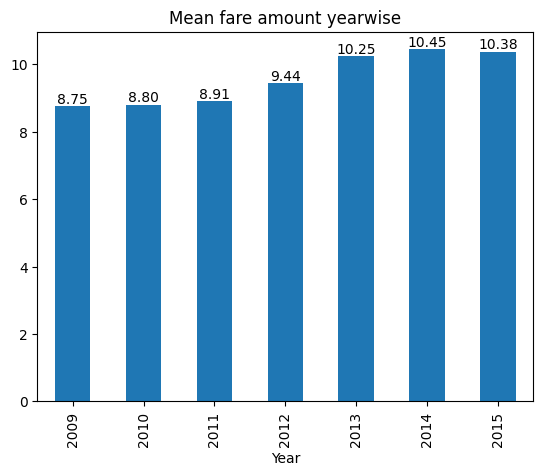

In [219]:
ax=final_df.groupby(['Year'])['fare_amount'].mean().plot(kind='bar')
plt.bar_label(ax.containers[0],fmt='%.2f')
plt.title('Mean fare amount yearwise')
plt.show()

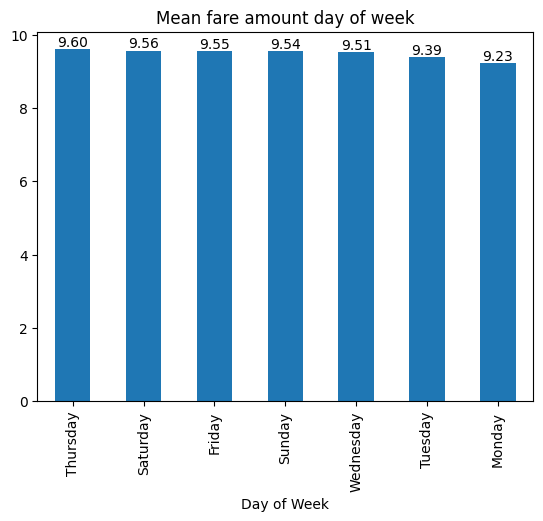

In [220]:
ax=final_df.groupby(['Day of Week'])['fare_amount'].mean().nlargest(10).plot(kind='bar')
plt.bar_label(ax.containers[0],fmt='%.2f')
plt.title('Mean fare amount day of week')
plt.show()

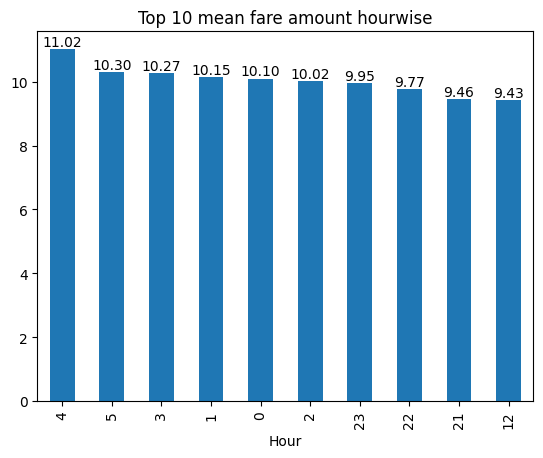

In [221]:
ax=final_df.groupby(['Hour'])['fare_amount'].mean().nlargest(10).plot(kind='bar')
plt.bar_label(ax.containers[0],fmt='%.2f')
plt.title('Top 10 mean fare amount hourwise')
plt.show()

#### 1.Mean fare amount shows an inreasing trend over the years.
#### 2.Fare amount of Monday and Tuesday, is definitely the least while remaining days have similar fare amounts.
#### 3.Fare amounts tend to be highest at the early hours and midnight.

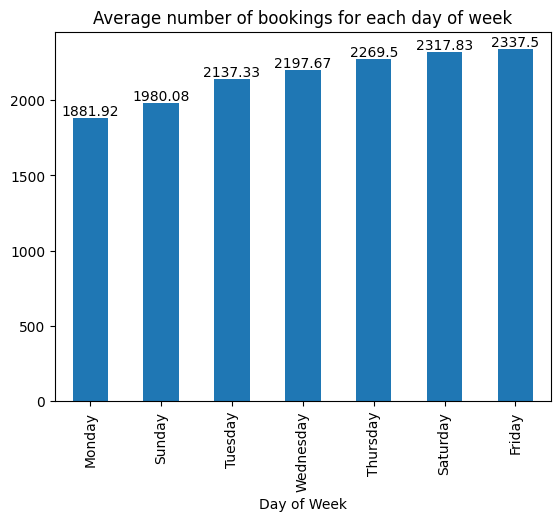

In [222]:
ax=final_df.groupby('Month')['Day of Week'].value_counts().groupby('Day of Week').mean().sort_values().plot(kind='bar')
plt.bar_label(ax.containers[0])
plt.title('Average number of bookings for each day of week')
plt.show()

#### As per the dataset, most number of bookings is seen on Friday.

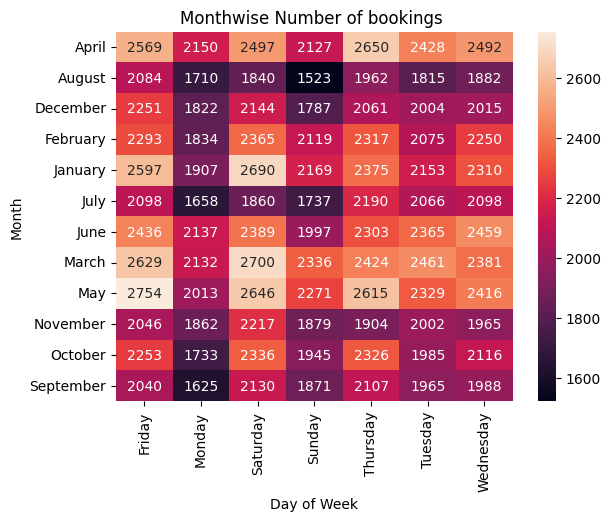

In [223]:
data2=final_df.groupby('Month')['Day of Week'].value_counts().unstack()
sns.heatmap(data2,annot=True,fmt='d')
# Show the plot
plt.title('Monthwise Number of bookings ')
plt.show()


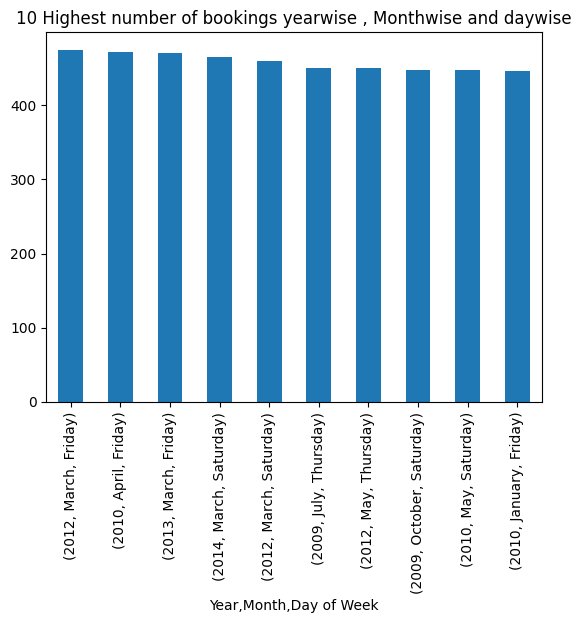

In [224]:
final_df.groupby(['Year','Month'])['Day of Week'].value_counts().nlargest(10).plot(kind='bar')
plt.title('10 Highest number of bookings yearwise , Monthwise and daywise')
plt.show()

### Over the years, it can be seen that most bookings have been done on , Friday or Saturday.

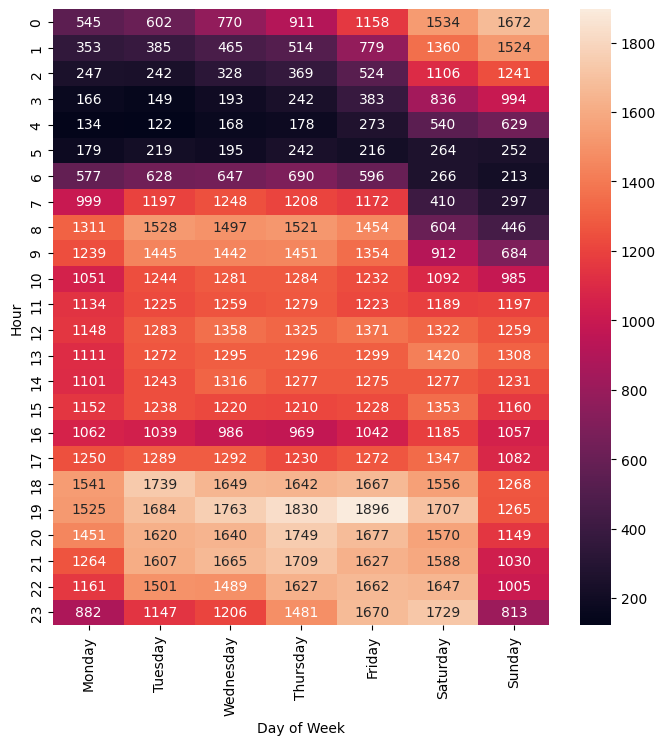

In [225]:
data3=final_df.groupby(['Day of Week'])['Hour'].value_counts().unstack().T.reindex(columns=day_order)
# Increase the figure size
plt.figure(figsize=(8, 8))
sns.heatmap(data3,annot=True,fmt='d')
plt.show()

#### 1. Maximum bookings happen after 19:00hrs.  
#### 2. We could see lesser bookings at the early hours.

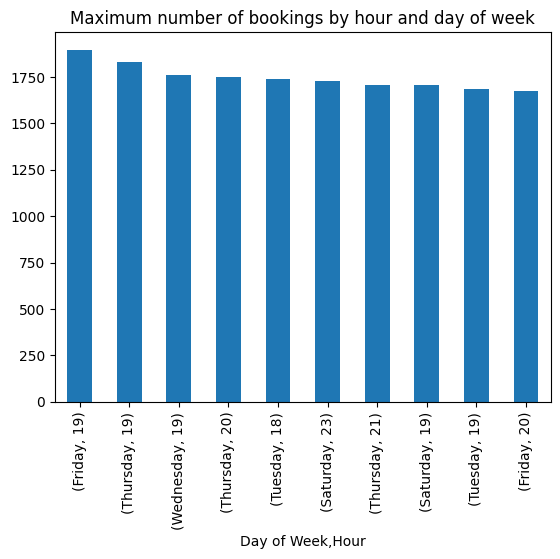

In [226]:
final_df.groupby(['Day of Week'])['Hour'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Maximum number of bookings by hour and day of week')
plt.show()

### One Hot encoding

In [227]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181462 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   key                 181462 non-null  object             
 1   fare_amount         181462 non-null  float64            
 2   pickup_datetime     181462 non-null  datetime64[ns, UTC]
 3   pickup_longitude    181462 non-null  float64            
 4   pickup_latitude     181462 non-null  float64            
 5   dropoff_longitude   181462 non-null  float64            
 6   dropoff_latitude    181462 non-null  float64            
 7   passenger_count     181462 non-null  int64              
 8   Year                181462 non-null  int64              
 9   Date                181462 non-null  int64              
 10  Hour                181462 non-null  int64              
 11  Month               181462 non-null  object             
 12  Day of Week     

In [228]:
model_data=final_df.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','key'],axis=1)

In [229]:
model_data

fare_amount  passenger_count  Year  Date  Hour    Month Day of Week  \
0               7.5                1  2015     7    19      May    Thursday   
1               7.7                1  2009    17    20     July      Friday   
2              12.9                1  2009    24    21   August      Monday   
3               5.3                3  2009    26     8     June      Friday   
4              16.0                5  2014    28    17   August    Thursday   
...             ...              ...   ...   ...   ...      ...         ...   
199994         12.0                1  2014    31    14  January      Friday   
199995          3.0                1  2012    28    10  October      Sunday   
199996          7.5                1  2014    14     1    March      Friday   
199998         14.5                1  2015    20    14      May   Wednesday   
199999         14.1                1  2010    15     4      May    Saturday   

        manhattan_distance  
0                 0.015442  
1                 0.022455  
2                 0.074355  
3                 0.023313  
4                 0.065221  
...                    ...  
199994            0.016691  
199995            0.001447  
199996            0.024733  
199998            0.043945  
199999            0.049829  

[181462 rows x 8 columns]

In [230]:
model_data['Year']=model_data['Year'].astype('category')
model_data['Date']=model_data['Date'].astype('category')
model_data['Hour']=model_data['Hour'].astype('category')
model_data['passenger_count']=model_data['passenger_count'].astype('category')

In [231]:
data=pd.get_dummies(model_data,drop_first=True)
data

fare_amount  manhattan_distance  passenger_count_2  passenger_count_3  \
0               7.5            0.015442                  0                  0   
1               7.7            0.022455                  0                  0   
2              12.9            0.074355                  0                  0   
3               5.3            0.023313                  0                  1   
4              16.0            0.065221                  0                  0   
...             ...                 ...                ...                ...   
199994         12.0            0.016691                  0                  0   
199995          3.0            0.001447                  0                  0   
199996          7.5            0.024733                  0                  0   
199998         14.5            0.043945                  0                  0   
199999         14.1            0.049829                  0                  0   

        passenger_count_4  passenger_count_5  passenger_count_6  Year_2010  \
0                       0                  0                  0          0   
1                       0                  0                  0          0   
2                       0                  0                  0          0   
3                       0                  0                  0          0   
4                       0                  1                  0          0   
...                   ...                ...                ...        ...   
199994                  0                  0                  0          0   
199995                  0                  0                  0          0   
199996                  0                  0                  0          0   
199998                  0                  0                  0          0   
199999                  0                  0                  0          1   

        Year_2011  Year_2012  ...  Month_May  Month_November  Month_October  \
0               0          0  ...          1               0              0   
1               0          0  ...          0               0              0   
2               0          0  ...          0               0              0   
3               0          0  ...          0               0              0   
4               0          0  ...          0               0              0   
...           ...        ...  ...        ...             ...            ...   
199994          0          0  ...          0               0              0   
199995          0          1  ...          0               0              1   
199996          0          0  ...          0               0              0   
199998          0          0  ...          1               0              0   
199999          0          0  ...          1               0              0   

        Month_September  Day of Week_Monday  Day of Week_Saturday  \
0                     0                   0                     0   
1                     0                   0                     0   
2                     0                   1                     0   
3                     0                   0                     0   
4                     0                   0                     0   
...                 ...                 ...                   ...   
199994                0                   0                     0   
199995                0                   0                     0   
199996                0                   0                     0   
199998                0                   0                     0   
199999                0                   0                     1   

        Day of Week_Sunday  Day of Week_Thursday  Day of Week_Tuesday  \
0                        0                     1                    0   
1                        0                     0                    0   
2                        0                     0                    0   
3                        0  

In [232]:
data.corr()['fare_amount'].sort_values(ascending=False).head(10) ## Top 10 correlated feature.

fare_amount           1.000000
manhattan_distance    0.833600
Year_2014             0.079929
Year_2013             0.065204
Year_2015             0.048592
Hour_4                0.032807
Hour_1                0.023291
Hour_23               0.020817
Hour_3                0.020250
Month_October         0.016651
Name: fare_amount, dtype: float64

In [233]:
data.corr()['fare_amount'].sort_values(ascending=True).head(10) ## Top 10 negatively correlated feature.

Year_2010            -0.058523
Year_2011            -0.050322
Month_January        -0.025618
Hour_7               -0.020032
Day of Week_Monday   -0.019995
Hour_6               -0.017721
Hour_16              -0.012859
Month_February       -0.011119
Month_March          -0.010880
Hour_10              -0.009967
Name: fare_amount, dtype: float64

In [234]:
X=data.drop('fare_amount',axis=1)# predictor Variable
X

manhattan_distance  passenger_count_2  passenger_count_3  \
0                 0.015442                  0                  0   
1                 0.022455                  0                  0   
2                 0.074355                  0                  0   
3                 0.023313                  0                  1   
4                 0.065221                  0                  0   
...                    ...                ...                ...   
199994            0.016691                  0                  0   
199995            0.001447                  0                  0   
199996            0.024733                  0                  0   
199998            0.043945                  0                  0   
199999            0.049829                  0                  0   

        passenger_count_4  passenger_count_5  passenger_count_6  Year_2010  \
0                       0                  0                  0          0   
1                       0                  0                  0          0   
2                       0                  0                  0          0   
3                       0                  0                  0          0   
4                       0                  1                  0          0   
...                   ...                ...                ...        ...   
199994                  0                  0                  0          0   
199995                  0                  0                  0          0   
199996                  0                  0                  0          0   
199998                  0                  0                  0          0   
199999                  0                  0                  0          1   

        Year_2011  Year_2012  Year_2013  ...  Month_May  Month_November  \
0               0          0          0  ...          1               0   
1               0          0          0  ...          0               0   
2               0          0          0  ...          0               0   
3               0          0          0  ...          0               0   
4               0          0          0  ...          0               0   
...           ...        ...        ...  ...        ...             ...   
199994          0          0          0  ...          0               0   
199995          0          1          0  ...          0               0   
199996          0          0          0  ...          0               0   
199998          0          0          0  ...          1               0   
199999          0          0          0  ...          1               0   

        Month_October  Month_September  Day of Week_Monday  \
0                   0                0                   0   
1                   0                0                   0   
2                   0                0                   1   
3                   0                0                   0   
4                   0                0                   0   
...               ...              ...                 ...   
199994              0                0                   0   
199995              1                0                   0   
199996              0                0                   0   
199998              0                0                   0   
199999              0                0                   0   

        Day of Week_Saturday  Day of Week_Sunday  Day of Week_Thursday  \
0                          0                   0                     1   
1                          0                   0                     0   
2                          0                   0                     0   
3                          0                   0                     0   
4                          0                   0                     1   
...                      ...                 ...                   ...   
199994                     0                   0                     0   
199995          

In [235]:
y=data.iloc[:,0] # Target Variable
y

0          7.5
1          7.7
2         12.9
3          5.3
4         16.0
          ... 
199994    12.0
199995     3.0
199996     7.5
199998    14.5
199999    14.1
Name: fare_amount, Length: 181462, dtype: float64

In [236]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [237]:
X_train

manhattan_distance  passenger_count_2  passenger_count_3  \
134218            0.040758                  1                  0   
128438            0.027695                  0                  0   
51710             0.013095                  1                  0   
140226            0.032950                  0                  0   
119694            0.017444                  0                  0   
...                    ...                ...                ...   
132138            0.035791                  0                  0   
114290            0.055355                  0                  0   
145370            0.030588                  1                  0   
161920            0.019592                  0                  0   
134408            0.017682                  0                  0   

        passenger_count_4  passenger_count_5  passenger_count_6  Year_2010  \
134218                  0                  0                  0          0   
128438                  0                  0                  0          0   
51710                   0                  0                  0          0   
140226                  0                  0                  0          0   
119694                  0                  0                  0          0   
...                   ...                ...                ...        ...   
132138                  0                  0                  0          0   
114290                  0                  0                  0          0   
145370                  0                  0                  0          0   
161920                  0                  0                  0          0   
134408                  0                  1                  0          0   

        Year_2011  Year_2012  Year_2013  ...  Month_May  Month_November  \
134218          1          0          0  ...          0               0   
128438          0          1          0  ...          0               0   
51710           0          0          1  ...          0               0   
140226          0          0          0  ...          0               0   
119694          0          1          0  ...          0               0   
...           ...        ...        ...  ...        ...             ...   
132138          0          0          0  ...          1               0   
114290          0          0          1  ...          0               0   
145370          0          0          1  ...          0               1   
161920          0          1          0  ...          0               0   
134408          0          0          1  ...          0               0   

        Month_October  Month_September  Day of Week_Monday  \
134218              0                0                   0   
128438              0                1                   1   
51710               0                0                   0   
140226              0                0                   1   
119694              0                0                   0   
...               ...              ...                 ...   
132138              0                0                   1   
114290              0                0                   0   
145370              0                0                   0   
161920              0                0                   0   
134408              0                0                   0   

        Day of Week_Saturday  Day of Week_Sunday  Day of Week_Thursday  \
134218                     0                   0                     0   
128438                     0                   0                     0   
51710                      0                   0                     0   
140226                     0                   0                     0   
119694                     0                   0                     0   
...                      ...                 ...                   ...   
132138                     0                   0                     0   
114290          

In [238]:
from sklearn.preprocessing import StandardScaler
# Standardize the feature matrix
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Applying Linear regression model

### Fitting OLS model on training dataset

In [239]:
import statsmodels.api as sm

# Fit the linear regression model
X_train_ols = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train, X_train_ols)
results = model.fit()

# Get the summary of the model
summary = results.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     4735.
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        16:40:21   Log-Likelihood:            -3.4450e+05
No. Observations:              145169   AIC:                         6.892e+05
Df Residuals:                  145086   BIC:                         6.900e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4834      0.007   1391.203      0.0

### Using OLS for prediction

In [240]:
X_test_ols = sm.add_constant(X_test_scaled) ## Adding constant term to
y_pred_ols = results.predict(X_test_ols)
# Predict on the test data using the OLS model

r2_ols = r2_score(y_test, y_pred_ols)
rmse_ols = mean_squared_error(y_test, y_pred_ols, squared=False)

# Print the evaluation metrics
print("OLS R-squared score:", r2_ols)
print("OLS RMSE:", rmse_ols)

OLS R-squared score: 0.7399129998129286
OLS RMSE: 2.5546066021764937


### Using Sklearn's Linear Regression.

### using cross validation

In [241]:
# Create an instance of the Linear Regression model
model = LinearRegression(fit_intercept=True)

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Perform cross-validation with MSE, RMSE, and R-squared as the scoring metrics
scoring = ['neg_mean_squared_error', 'r2']
cv_results = cross_validate(model, X_train_scaled, y_train, cv=5, scoring=scoring)

# Extract the scores from cross-validation results
mse_scores = -cv_results['test_neg_mean_squared_error']
rmse_scores = np.sqrt(mse_scores)
r2_scores = cv_results['test_r2']

# Calculate the average MSE, RMSE, and R-squared score
average_mse = np.mean(mse_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

# Print the cross-validation scores, average MSE, RMSE, and R-squared score
print("Cross-Validation Scores (MSE):", mse_scores)
print("Cross-Validation Scores (RMSE):", rmse_scores)
print("Cross-Validation Scores (R-squared):", r2_scores)
print("Average MSE:", average_mse)
print("Average RMSE:", average_rmse)
print("Average R-squared:", average_r2)

Cross-Validation Scores (MSE): [6.82755988 6.70583718 6.61055044 6.71534773 6.89355521]
Cross-Validation Scores (RMSE): [2.61295998 2.58956313 2.57109907 2.5913988  2.62555808]
Cross-Validation Scores (R-squared): [0.72480878 0.73266726 0.73220517 0.72916314 0.71915543]
Average MSE: 6.750570089063665
Average RMSE: 2.5981158113953633
Average R-squared: 0.7275999573233999


In [242]:
# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate MSE, RMSE, and R-squared score for test data
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (MSE) by mean on test set: {:.4f}".format(rmse_mean))
print("R-squared score (Test):", r2)

The mean absolute error (MAE) on test set: 1.7829
The mean squared error (MSE) on test set: 6.5260
The root mean squared error (RMSE) on test set: 2.5546
The root mean squared error (MSE) by mean on test set: 0.2684
R-squared score (Test): 0.7399129998129286


In [243]:
X_test

manhattan_distance  passenger_count_2  passenger_count_3  \
100321            0.052811                  0                  0   
93170             0.029411                  0                  0   
86125             0.044664                  0                  0   
54027             0.023616                  0                  0   
175525            0.027761                  0                  0   
...                    ...                ...                ...   
175509            0.016644                  0                  0   
100313            0.143552                  0                  0   
52330             0.062777                  0                  0   
133652            0.057505                  1                  0   
88235             0.036757                  0                  0   

        passenger_count_4  passenger_count_5  passenger_count_6  Year_2010  \
100321                  0                  0                  0          0   
93170                   0                  1                  0          1   
86125                   0                  0                  0          0   
54027                   0                  0                  0          0   
175525                  0                  0                  0          0   
...                   ...                ...                ...        ...   
175509                  0                  0                  0          0   
100313                  0                  1                  0          0   
52330                   0                  0                  0          0   
133652                  0                  0                  0          0   
88235                   0                  1                  0          0   

        Year_2011  Year_2012  Year_2013  ...  Month_May  Month_November  \
100321          1          0          0  ...          1               0   
93170           0          0          0  ...          0               0   
86125           0          0          0  ...          0               0   
54027           0          1          0  ...          0               0   
175525          0          0          1  ...          0               0   
...           ...        ...        ...  ...        ...             ...   
175509          0          0          1  ...          1               0   
100313          1          0          0  ...          0               0   
52330           0          0          0  ...          0               0   
133652          0          1          0  ...          0               0   
88235           1          0          0  ...          0               0   

        Month_October  Month_September  Day of Week_Monday  \
100321              0                0                   0   
93170               0                0                   0   
86125               1                0                   0   
54027               0                0                   0   
175525              0                0                   0   
...               ...              ...                 ...   
175509              0                0                   0   
100313              1                0                   0   
52330               0                0                   0   
133652              0                0                   0   
88235               0                0                   0   

        Day of Week_Saturday  Day of Week_Sunday  Day of Week_Thursday  \
100321                     0                   0                     1   
93170                      0                   0                     0   
86125                      0                   0                     1   
54027                      0                   0                     0   
175525                     0                   0                     0   
...                      ...                 ...                   ...   
175509                     0                   0                     0   
100313          

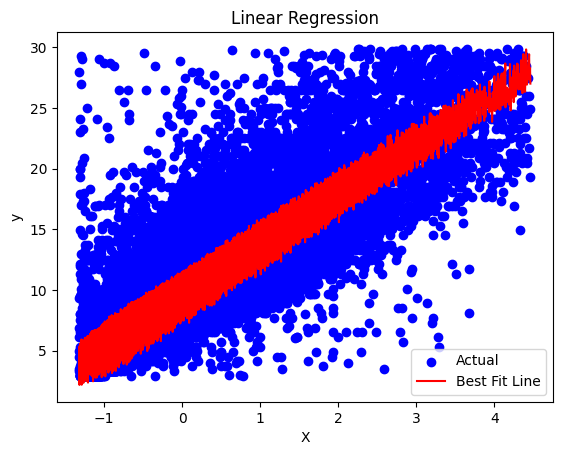

In [244]:
# Sort the values for a smoother line plot
sorted_indexes = np.argsort(X_test_scaled[:, 0])
X_test_sorted = X_test_scaled[sorted_indexes]
y_pred_sorted = y_pred[sorted_indexes]

# Plot the data points
plt.scatter(X_test_scaled[:, 0], y_test, color='b', label='Actual')

# Plot the best fit line
plt.plot(X_test_sorted[:, 0], y_pred_sorted, color='r', label='Best Fit Line')

# Add labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')

# Show the legend
plt.legend()

# Show the plot
plt.show()


### Check for heteroskedasticity of residuals

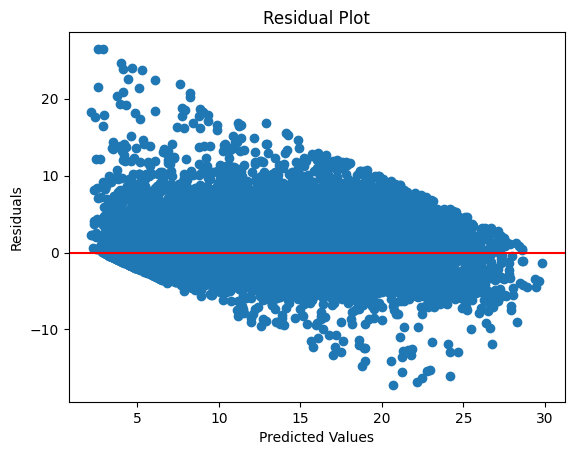

In [245]:
residuals = y_test - y_pred_ols

## residuals against the predicted values

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Statistical check for heteroskedasticity.

In [246]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform the Breusch-Pagan test
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, X_test)

# Print the p-value of the Breusch-Pagan test
print("Breusch-Pagan test p-value: ", lm_pvalue)

if lm_pvalue < 0.05:
    print("The null hypothesis is rejected. There is evidence of heteroskedasticity.")
else:
    print("The null hypothesis is not rejected. There is no significant evidence of heteroskedasticity.")


Breusch-Pagan test p-value:  0.0
The null hypothesis is rejected. There is evidence of heteroskedasticity.


### Find autocorrelation of residuals

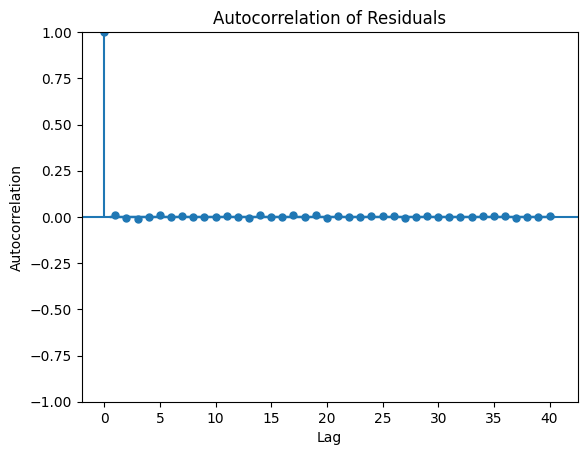

In [247]:
# Plot the autocorrelation of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)

# Set plot title and labels
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# Display the plot
plt.show()

### Statistical check for  auto correlation

In [248]:
# Perform the Durbin-Watson test
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)

# Print the Durbin-Watson test statistic
print("Durbin-Watson test statistic:", durbin_watson_statistic)

Durbin-Watson test statistic: 1.9763303712807088


#### A value close to 2 suggests no significant autocorrelation, between the residuals which can be seen in the plot.

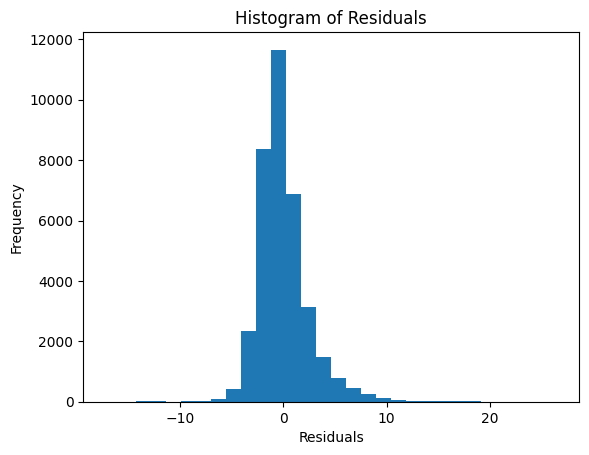

In [249]:
# Plot histogram of residuals
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

### QQ Plot of residuals

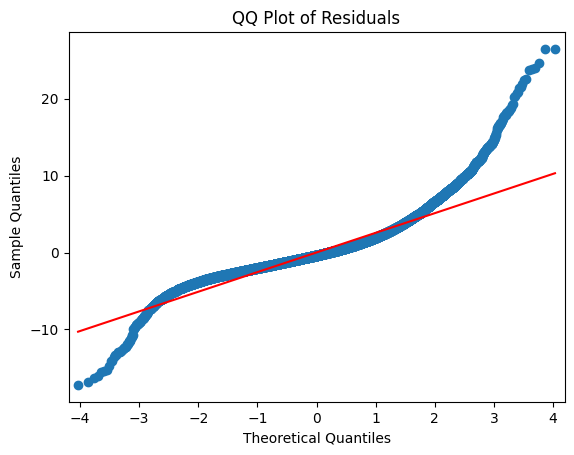

In [250]:
sm.qqplot(residuals, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

## Statistical check for normality of residuals

In [251]:
# Checking if residual is normal or not.
stat, p_value = shapiro(residuals)

alpha = 0.05  # Set significance level
if p_value > alpha:
    print("Residuals follow a normal distribution.")
else:
    print("Residuals do not follow a normal distribution.")


Residuals do not follow a normal distribution.


In [252]:
# Calculate the Jarque-Bera test statistic and p-value
jb_stat, jb_p_value = stats.jarque_bera(residuals)

# Print the results
print("P-value:", jb_p_value)

if jb_p_value > alpha:
    print("The residuals are approximately normally distributed.")
else:
    print("The residuals do not follow a normal distribution.")

P-value: 0.0
The residuals do not follow a normal distribution.


Although, our linear regression model gives improved results in test compared to train data,
but we can see our linear model does not follow the assumptions. Hence, It can not be generalised.


### Applying Lasso Regression and feature selection

In [253]:
# Step 4: Initialize and Fit the Lasso Regression Model
lasso = Lasso(alpha=0.1,fit_intercept=True)  # Set the regularization strength (alpha)
lasso.fit(X_train_scaled, y_train)

# Step 5: Evaluate the Model
y_pred = lasso.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)

# Calculate the adjusted R-squared
n = X_test_scaled.shape[0]  # number of samples
p = X_test_scaled.shape[1]  # number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (MSE) by mean on test set: {:.4f}".format(rmse_mean))
print("R-squared:", r2)
print("Adjusted R-squared:", adj_r2)

The mean absolute error (MAE) on test set: 1.8374
The mean squared error (MSE) on test set: 6.8456
The root mean squared error (RMSE) on test set: 2.6164
The root mean squared error (MSE) by mean on test set: 0.2749
R-squared: 0.7271761389488083
Adjusted R-squared: 0.7265583108182865


In [254]:
# Get the coefficients of the features
feature_coef = dict(zip(X.columns, lasso.coef_))
feature_coef

{'manhattan_distance': 4.057371865600296,
 'passenger_count_2': 0.0,
 'passenger_count_3': 0.0,
 'passenger_count_4': 0.0,
 'passenger_count_5': 0.0,
 'passenger_count_6': 0.0,
 'Year_2010': -0.058859361586012925,
 'Year_2011': -0.017885810976420835,
 'Year_2012': 0.0,
 'Year_2013': 0.35409912814548455,
 'Year_2014': 0.42197785742947896,
 'Year_2015': 0.28026629426565597,
 'Date_2': -0.0,
 'Date_3': -0.0,
 'Date_4': 0.0,
 'Date_5': -0.0,
 'Date_6': 0.0,
 'Date_7': -0.0,
 'Date_8': 0.0,
 'Date_9': 0.0,
 'Date_10': -0.0,
 'Date_11': -0.0,
 'Date_12': 0.0,
 'Date_13': 0.0,
 'Date_14': 0.0,
 'Date_15': -0.0,
 'Date_16': -0.0,
 'Date_17': 0.0,
 'Date_18': 0.0,
 'Date_19': 0.0,
 'Date_20': 0.0,
 'Date_21': 0.0,
 'Date_22': -0.0,
 'Date_23': 0.0,
 'Date_24': -0.0,
 'Date_25': -0.0,
 'Date_26': -0.0,
 'Date_27': -0.0,
 'Date_28': -0.0,
 'Date_29': -0.0,
 'Date_30': 0.0,
 'Date_31': -0.0,
 'Hour_1': -0.0,
 'Hour_2': -0.006421135494087769,
 'Hour_3': -0.0,
 'Hour_4': -0.0,
 'Hour_5': -0.0,
 'Hou

In [255]:
important_features = [feature for feature, coef in feature_coef.items() if coef != 0.0]
print(important_features)

['manhattan_distance', 'Year_2010', 'Year_2011', 'Year_2013', 'Year_2014', 'Year_2015', 'Hour_2', 'Hour_6', 'Hour_7', 'Hour_12', 'Day of Week_Sunday']


In [256]:
selected_features=data.columns[data.columns.isin(important_features)]
imp_feature=data[selected_features]
imp_feature

manhattan_distance  Year_2010  Year_2011  Year_2013  Year_2014  \
0                 0.015442          0          0          0          0   
1                 0.022455          0          0          0          0   
2                 0.074355          0          0          0          0   
3                 0.023313          0          0          0          0   
4                 0.065221          0          0          0          1   
...                    ...        ...        ...        ...        ...   
199994            0.016691          0          0          0          1   
199995            0.001447          0          0          0          0   
199996            0.024733          0          0          0          1   
199998            0.043945          0          0          0          0   
199999            0.049829          1          0          0          0   

        Year_2015  Hour_2  Hour_6  Hour_7  Hour_12  Day of Week_Sunday  
0               1       0       0       0        0                   0  
1               0       0       0       0        0                   0  
2               0       0       0       0        0                   0  
3               0       0       0       0        0                   0  
4               0       0       0       0        0                   0  
...           ...     ...     ...     ...      ...                 ...  
199994          0       0       0       0        0                   0  
199995          0       0       0       0        0                   1  
199996          0       0       0       0        0                   0  
199998          1       0       0       0        0                   0  
199999          0       0       0       0        0                   0  

[181462 rows x 11 columns]

In [257]:
X1=imp_feature

In [258]:
# Split the data into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [259]:
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

### We are using the selected features from lasso to apply the polynomial regression Model.

In [260]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
X1_train_poly = poly_features.fit_transform(X1_train_scaled)
X1_test_poly = poly_features.transform(X1_test_scaled)

In [261]:
poly_regression = LinearRegression()
poly_regression.fit(X1_train_poly, y1_train)

LinearRegression()

In [262]:
y1_pred = poly_regression.predict(X1_test_poly)

# Calculate evaluation metrics
mae = mean_absolute_error(y1_test, y1_pred)
mse = mean_squared_error(y1_test, y1_pred,squared=True)
rmse = mean_squared_error(y1_test, y1_pred,squared=False)
rmse_mean=mean_squared_error(y1_test, y1_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 1.7863
The mean squared error (MSE) on test set: 6.5702
The root mean squared error (RMSE) on test set: 2.5632
The root mean squared error (RMSE) by mean on test set: 0.2693


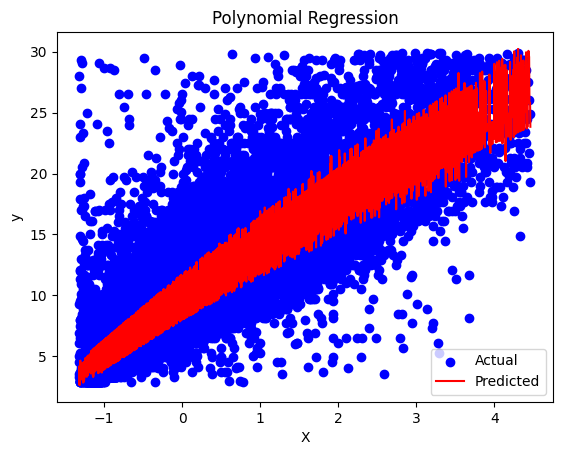

In [263]:
# Sort the values for a smoother line plot
sorted_indexes = np.argsort(X1_test_poly[:, 1])
X1_test_sorted = X1_test_poly[sorted_indexes]
y1_pred_sorted = y1_pred[sorted_indexes]

# Plot the data points
plt.scatter(X1_test_poly[:, 1], y1_test, color='b', label='Actual')

# Plot the best fit curve
plt.plot(X1_test_sorted[:, 1], y1_pred_sorted, color='r', label='Predicted')

# Add labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title('Polynomial Regression')

# Show the legend
plt.legend()

# Show the plot
plt.show()

### Decision Tree Regression Model

In [264]:
# Create an instance of DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict using the trained model
y3_pred = model.predict(X_test)

# Evaluate the model

mae = mean_absolute_error(y_test, y3_pred)
mse = mean_squared_error(y_test, y3_pred,squared=True)
rmse = mean_squared_error(y_test, y3_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y3_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 2.4201
The mean squared error (MSE) on test set: 12.2100
The root mean squared error (RMSE) on test set: 3.4943
The root mean squared error (RMSE) by mean on test set: 0.3672


### Hyperparameter Tuning of Decision Tree

In [265]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': randint(1, 10),              # Maximum depth of the tree
    'min_samples_split': randint(2, 10),       # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),        # Minimum number of samples required to be at a leaf node
    'max_features': ['auto','sqrt','log2'],                    # Number of features to consider at each split
}

# Create an instance of RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5,random_state=42)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error (MSE)
print("Best Hyperparameters:", random_search.best_params_)
print("Best MSE:", -random_search.best_score_)

# Obtain the best model from the random search
best_model = random_search.best_estimator_


Best Hyperparameters: {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 9}
Best MSE: 6.8149886841056


In [266]:
# Predict using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 1.8043
The mean squared error (MSE) on test set: 6.6167
The root mean squared error (RMSE) on test set: 2.5723
The root mean squared error (RMSE) by mean on test set: 0.2703


### Random Forest Regression Model

In [267]:
# Create an instance of RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict using the trained model
y4_pred= model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y4_pred)
mse = mean_squared_error(y_test, y4_pred,squared=True)
rmse = mean_squared_error(y_test, y4_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y4_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 1.8004
The mean squared error (MSE) on test set: 6.6429
The root mean squared error (RMSE) on test set: 2.5774
The root mean squared error (RMSE) by mean on test set: 0.2708


### AdaBoost Regression Model

In [268]:
# Create an instance of AdaBoostRegressor
model = AdaBoostRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict using the trained model
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 4.3512
The mean squared error (MSE) on test set: 23.9100
The root mean squared error (RMSE) on test set: 4.8898
The root mean squared error (RMSE) by mean on test set: 0.5138


In [269]:
# Create an instance of DecisionTreeRegressor as the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3,random_state=42)

# Create an instance of AdaBoostRegressor with the decision tree base estimator
model = AdaBoostRegressor(base_estimator=base_estimator)

# Train the model
model.fit(X_train, y_train)

# Predict using the trained model
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 2.8966
The mean squared error (MSE) on test set: 11.9342
The root mean squared error (RMSE) on test set: 3.4546
The root mean squared error (RMSE) by mean on test set: 0.3630


### GradientBoostRegressor

In [270]:
reg = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=5, learning_rate=0.01, loss="squared_error",random_state=0)
reg.fit(X_train, y_train)

y_pred=reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred,squared=True)
rmse = mean_squared_error(y_test, y_pred,squared=False)
rmse_mean=mean_squared_error(y_test, y_pred,squared=False)/y_test.mean()


print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("The root mean squared error (RMSE) by mean on test set: {:.4f}".format(rmse_mean))

The mean absolute error (MAE) on test set: 1.7776
The mean squared error (MSE) on test set: 6.4021
The root mean squared error (RMSE) on test set: 2.5302
The root mean squared error (RMSE) by mean on test set: 0.2659


In [274]:
result_df= pd.DataFrame({'MAE':[1.7829,1.8374,1.7862,1.8043, 1.8004,4.1505,1.7776],
                         'MSE':[6.5260,6.8456,6.5708,6.6167,6.6429,21.8680,6.4021],
                         'RMSE':[2.5546,2.6164,2.5633,2.5723,2.5774, 4.6763,2.5302],
    'RMSE/(Mean of y in test)' : [0.2684,0.2749,0.2693,0.2703,0.2708,0.4914,0.2659]},
                 index=['Linear Regression','Lasso Regression','Polynomial Regression','Decision Tree Regressor(tuned)','Random Forest Regressor', 'Adaboost Regressor','GradientBoost Regressor'])
result_df

MAE      MSE    RMSE  \
Linear Regression               1.7829   6.5260  2.5546   
Lasso Regression                1.8374   6.8456  2.6164   
Polynomial Regression           1.7862   6.5708  2.5633   
Decision Tree Regressor(tuned)  1.8043   6.6167  2.5723   
Random Forest Regressor         1.8004   6.6429  2.5774   
Adaboost Regressor              4.1505  21.8680  4.6763   
GradientBoost Regressor         1.7776   6.4021  2.5302   

                                RMSE/(Mean of y in test)  
Linear Regression                                 0.2684  
Lasso Regression                                  0.2749  
Polynomial Regression                             0.2693  
Decision Tree Regressor(tuned)                    0.2703  
Random Forest Regressor                           0.2708  
Adaboost Regressor                                0.4914  
GradientBoost Regressor                           0.2659

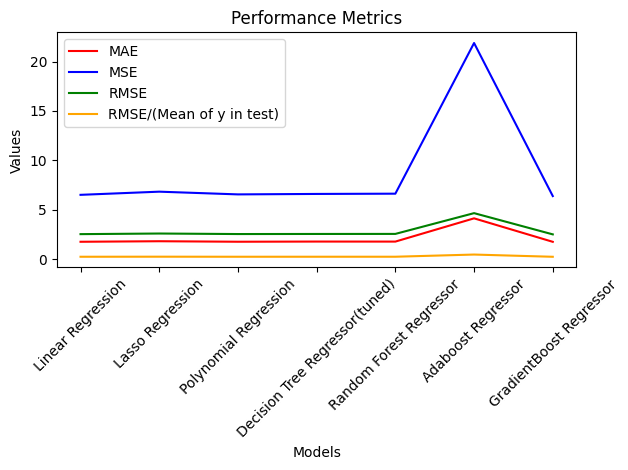

In [275]:
# Set the colors for each line
colors = ['red', 'blue', 'green', 'orange']

# Plot the line chart
result_df.plot(kind='line', color=colors)

# Set the title and labels
plt.title('Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Values')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Fix the overlapping issue
plt.tight_layout()

# Display the plot
plt.show()

### The best result has thus, been seen in Gradient Boosting Regression model.

## **Conclusions**

There is a scope of improving results in ensemble models. This can be explored through hyperparameter tuning. RandomSearchCV or GridsearchCV can be applied for same.

XGboost could have been used here for better results.

Choice of error metric- We have used MAE, MSE,RMSE and RMSE by mean of target to evaluate the model.